# Redução de Dimensionalidade


$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bV}{\mathbf{V}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bG}{\mathbf{G}}$
$\newcommand{\bg}{\mathbf{g}}$
$\newcommand{\bZ}{\mathbf{Z}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ipywidgets import interact

import requests, io, h5py

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def gen_data():
    rot = lambda theta: np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    X = [5, 7] + np.random.RandomState(0).randn(50, 2) @ np.diag([1.5, 0.5]) @ rot(40*np.pi/180)
    return X

def plot_data(X, X_rec=None):
    plt.plot(X[:, 0], X[:, 1], 'bo', ms=8, mec='k', mew=0.5)
    if X_rec is not None:
        for x, x_rec in zip(X, X_rec):
            plt.plot([x[0], x_rec[0]], [x[1], x_rec[1]], 'k--', lw=1)
        plt.plot(X_rec[:, 0], X_rec[:, 1], 'ro', ms=8, mec='k', mew=0.5)
    plt.axis('scaled')
    return

def display_images(X, n_cols=10, max_n_rows=6, scale=1.5):
    m, n = X.shape
    d = int(np.round(np.sqrt(n)))
    assert n == d**2
    n_rows = min(int(np.ceil(m/n_cols)), max_n_rows)
    plt.figure(figsize=(n_cols*scale, n_rows*scale))
    for i in range(min(m, n_rows*n_cols)):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(X[i].reshape(d,d), cmap=plt.cm.gray);
        plt.axis('off');
    return

# PCA

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

## Conceitos básicos

(50, 2)


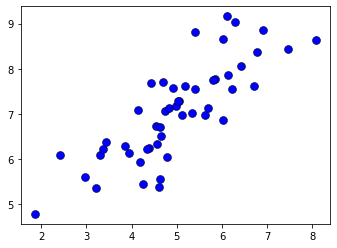

In [2]:
X = gen_data()
plot_data(X)
print(X.shape)

Vamos rodar o algoritmo PCA (`sklearn.decomposition.PCA`) com $K=n=2$, obtendo o vetor de média $\bmu$, os autovetores $\bg_1,\ldots,\bg_n$ e seus respectivos autovalores $\lambda_1,\ldots,\lambda_n$.

In [3]:
# The input data is centered but not scaled for each feature before applying the SVD.

K = 2
model = PCA(K)
model.fit(X)

PCA(n_components=2)

In [4]:
mu = X.mean(axis=0)
mu

array([4.98626895, 7.05558265])

In [5]:
mu = model.mean_
mu

array([4.98626895, 7.05558265])

In [6]:
# components_ : ndarray of shape (n_components, n_features) The components are sorted by ``explained_variance_``.
Gt = model.components_
Gt

array([[-0.77347907, -0.63382184],
       [-0.63382184,  0.77347907]])

In [7]:
lambdas = model.explained_variance_
lambdas

array([2.43449395, 0.24657229])

In [8]:
sigmas = model.singular_values_
sigmas

array([10.92200547,  3.4759232 ])

Lembre que $\lambda_k = \sigma_k^2/m$ (ou $\lambda_k = \sigma_k^2/(m-1)$ se a estimativa da matriz de covariância for não-enviesada)

In [9]:
sigmas**2/(len(X) - 1)  # == model.explained_variance_

array([2.43449395, 0.24657229])

In [10]:
model.explained_variance_ratio_  # == model.explained_variance_/model.explained_variance_.sum()

array([0.908032, 0.091968])

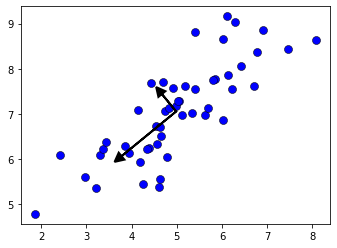

In [11]:
v = Gt
v = np.diag(np.sqrt(lambdas)) @ Gt

plot_data(X)
for i in range(2):
    plt.arrow(*model.mean_, *v[i], 
              head_width=0.2, head_length=0.2, fc='k', lw=2, zorder=1000);
    #text_offset = [[-0.7, -0.3], [-0.7, -0.1]]
    #plt.annotate('PC' + str(i+1), model.mean_ + h[i] + text_offset[i], c='r', weight='bold', size=12, zorder=2000)

As setas acima partem do ponto de média e vão na direção/sentido dos autovetores, com comprimento igual à raiz quadrada dos respectivos autovalores.

## Transformação e reconstrução

Vamos realizar a projeção em $K=1$ dimensão, obtendo as coordenadas $\bz$ neste novo espaço, e em seguida reconstruir os dados no espaço original ($n=2$) a partir destas coordenadas, i.e., aproximar os dados usando apenas a primeira componente principal.

In [12]:
X[:5]

array([[6.8984057 , 8.85413559],
       [5.404426  , 8.80199287],
       [7.46003969, 8.42634556],
       [6.1403602 , 7.85808442],
       [4.74943084, 7.05774665]])

In [13]:
K = 1
model = PCA(K)
model.fit(X)
model.components_

array([[-0.77347907, -0.63382184]])

- Notação vetores-coluna (slides):

  $\bz = \bG^T (\bx - \bmu)$

- Notação vetores-linha (sklearn):

  $\bz^T = \bG^T (\bx^T - \bmu^T) \implies \bz = (\bx - \bmu) \bG $

In [14]:
Z = (X - model.mean_) @ model.components_.T
Z[:5]

array([[-2.61895989],
       [-1.43034866],
       [-2.78222936],
       [-1.40130858],
       [ 0.18181773]])

In [15]:
# obs: Z = model.fit_transform(X)

Z = model.transform(X)
Z[:5]

array([[-2.61895989],
       [-1.43034866],
       [-2.78222936],
       [-1.40130858],
       [ 0.18181773]])

- Notação vetores-coluna (slides):

  $\hat{\bx} = \bmu + \bG \bz$

- Notação vetores-linha (sklearn):

  $\hat{\bx}^T = \bmu^T + \bG \bz^T \implies \hat{\bx} = \bmu + \bz \bG^T$

In [16]:
X_rec = model.mean_ + Z @ model.components_
X_rec[:5]

array([[7.01197961, 8.71553663],
       [6.0926137 , 7.96216887],
       [7.13826514, 8.81902039],
       [6.07015181, 7.94376263],
       [4.84563674, 6.94034261]])

In [17]:
X_rec  = model.inverse_transform(Z)
X_rec[:5]

array([[7.01197961, 8.71553663],
       [6.0926137 , 7.96216887],
       [7.13826514, 8.81902039],
       [6.07015181, 7.94376263],
       [4.84563674, 6.94034261]])

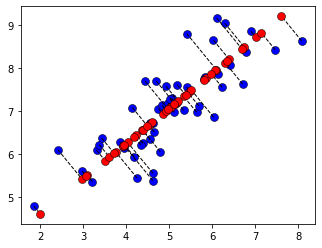

In [18]:
plot_data(X, X_rec)

# Autoencoders

Agora, vamos encontrar o primeiro componente principal (a menos de uma multiplicação por escalar, i.e., vamos encontrar a direção do primeiro componente principal) usando uma rede neural autoencoder de 1 camada oculta com ativação linear. Em geral, esse modelo é equivalente a PCA no sentido de encontrar o mesmo subespaço gerado pelos componentes principais (mas o treinamento do PCA é muito mais rápido).

Assim como no PCA, vamos garantir que os dados estão centralizados.

In [19]:
from sklearn.neural_network import MLPRegressor
mean = X.mean(axis=0)
Xc = X - mean
model = MLPRegressor(hidden_layer_sizes=[1], activation='identity', solver='lbfgs')
model.fit(Xc, Xc);

Relembrando:

- A camada oculta da rede neural produz a ativação

  $a = \bW^{[0]}\bx + b^{[0]}$, 
  
  onde $\bW^{[0]} = [w_{11}^{[0]}, w_{12}^{[0]}]$.
  
- A saída da rede neural é dada por 
  
  $\hat{\bx} = \bW^{[1]}a + \bb^{[1]}$, 
  
  onde $\bW^{[1]} = [w_{11}^{[1]}, w_{21}^{[1]}]^T$ e $\bb^{[1]} = [b_{1}^{[1]}, b_{2}^{[1]}]^T$.
  
- Portanto, 

  $\hat{\bx} = \bW^{[1]}(\bW^{[0]}\bx + b^{[0]}) + \bb^{[1]} = \bW^{[1]}\bW^{[0]}\bx + \bW^{[1]}b^{[0]} + \bb^{[1]}$
  
- Como o conjunto de treinamento possui média nula, devemos esperar encontrar $\bW^{[1]}b^{[0]} + \bb^{[1]} = \mathbf{0}$, de forma que 
  
  $\hat{\bx} = \bW^{[1]}\bW^{[0]}\bx$
  
  com $\bW^{[1]}$ e $\bW^{[0]}$ fazendo o papel de $\bG$ e $(\bG^T\bG)^{-1}\bG^T$, respectivamente (note que as colunas de $\bW^{[1]}$ não são necessariamente uma base ortonormal).

- Como o `sklearn` usa uma notação matricial transposta, ${\bW^{[i]}}$ é obtido como `model.coefs_[i].T`.

In [20]:
W0 = model.coefs_[0].T
W1 = model.coefs_[1].T
b0 = model.intercepts_[0].reshape(-1, 1)
b1 = model.intercepts_[1].reshape(-1, 1)
print('W0 =')
print(W0)
print('W1 =')
print(W1)
print('b0 =')
print(b0)
print('b1 =')
print(b1)

W0 =
[[0.66852079 0.54786241]]
W1 =
[[0.89492274]
 [0.73330547]]
b0 =
[[-0.74980441]]
b1 =
[[0.67105972]
 [0.5498922 ]]


In [21]:
print('Should be close to zero:')
print(W1 @ b0 + b1)

Should be close to zero:
[[4.26969004e-05]
 [5.65208268e-05]]


In [22]:
print('Should be close to 1:')
print(W0 @ W1)

Should be close to 1:
[[1.00002496]]


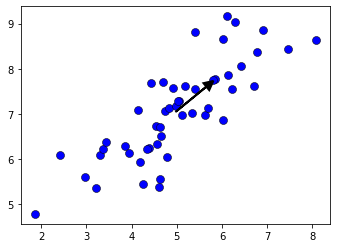

In [23]:
plot_data(X)
plt.arrow(*mean, *W0.reshape(-1), 
          head_width=0.2, head_length=0.2, fc='k', lw=2, zorder=1000);

- A transformação para o espaço reduzido e reconstrução são dadas por:

  $\bz = \bW^{[0]} \bx \quad$ e $\quad \hat{\bx} = \bW^{[1]} \bz$
  
  ou, usando a notação de vetor-linha (sklearn):
  
  $\bz = \bx {\bW^{[0]}}^T \quad$ e $\quad \hat{\bx} = \bz {\bW^{[1]}}^T$
  
- Isso assume que os dados estão centralizados. Caso contrário, temos:
  
  $\bz = (\bx - \bmu) {\bW^{[0]}}^T \quad$ e $\quad \hat{\bx} = \bmu + \bz {\bW^{[1]}}^T$  

In [24]:
Z = Xc @ W0.T
Z[:5]

array([[ 2.26366272],
       [ 1.23633919],
       [ 2.40475665],
       [ 1.21119455],
       [-0.15714562]])

In [25]:
X_rec = mean + Z @ W1.T
X_rec[:5]

array([[7.01207219, 8.71553891],
       [6.092697  , 7.96219695],
       [7.13834035, 8.81900386],
       [6.07019449, 7.94375824],
       [4.84563575, 6.94034691]])

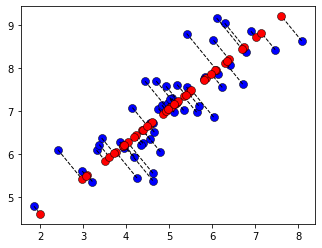

In [26]:
plot_data(X, X_rec)

# Exemplo: Eigenfaces

## Conjunto de dados

O conjunto de dados abaixo é uma versão redimensionada do conjunto [LFWcrop](https://conradsanderson.id.au/lfwcrop/) e consiste de imagens de faces com dimensões 32 x 32 em escala de cinza. O conjunto já está "achatado" em vetores de comprimento $n=1024$. 

In [27]:
url = 'https://github.com/danilo-silva-ufsc/ml-course/raw/master/data/faces.h5'
with h5py.File(io.BytesIO(requests.get(url).content), 'r') as file:
    X = file['X'][:]
print(X.shape, X.dtype)

(5000, 1024) int8


Um exemplo das primeiras 50 imagens é mostrado a seguir.

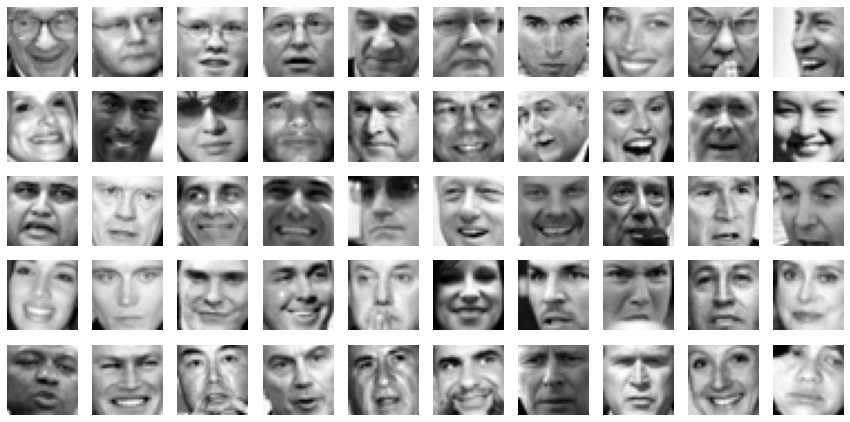

In [28]:
display_images(X[:50])

## Aplicando PCA

In [29]:
K = 100
model = PCA(K, random_state=0)
Z = model.fit_transform(X)
X_rec = model.inverse_transform(Z)

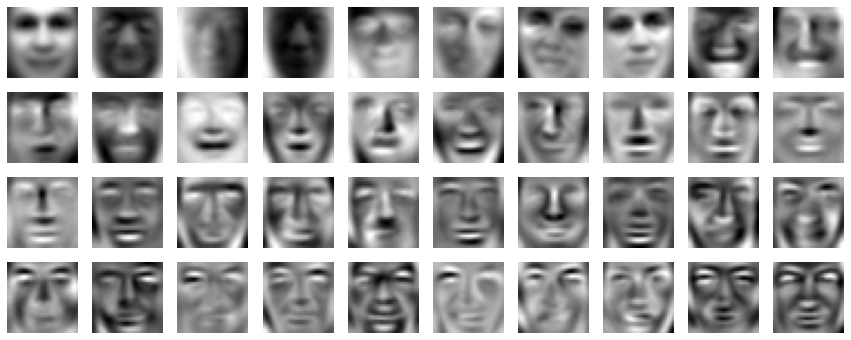

In [30]:
# Mean and first 39 principal components
display_images(np.r_[model.mean_.reshape(1, -1), model.components_[:39]])

In [31]:
# Original and reconstructed images
@interact(i=(0,9))
def _(i=0):
    display_images(np.r_[X[10*i:10*i+10], X_rec[10*i:10*i+10]])

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

## Escolhendo o número de componentes principais

Podemos determinar $K$ como o número de componentes principais necessários para obter uma determinada proporção de variância explicada.

In [32]:
%%time
model = PCA().fit(X)

Wall time: 1.1 s


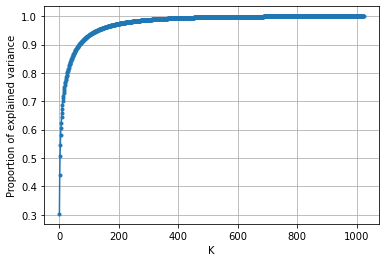

In [33]:
cumulative_explained_variance = np.cumsum(model.explained_variance_ratio_)
plt.plot(range(1, model.n_components_+1), cumulative_explained_variance, '.-');
plt.xlabel('K');
plt.ylabel('Proportion of explained variance');
plt.grid();

In [34]:
target_explained_variance = 0.99
K = np.where(cumulative_explained_variance >= target_explained_variance)[0][0] + 1
K

332

In [35]:
model.explained_variance_[:K].sum()/model.explained_variance_.sum()

0.9900666085749064

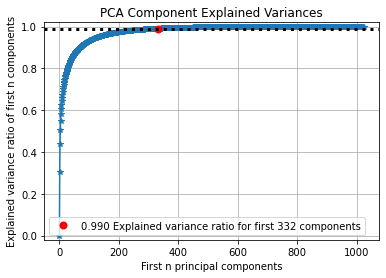

In [36]:
from scikitplot.decomposition import plot_pca_component_variance

plot_pca_component_variance(model, target_explained_variance=target_explained_variance);

In [37]:
%%time
model = PCA(target_explained_variance).fit(X)
K = model.n_components_
K

Wall time: 1.13 s


332

In [38]:
model.explained_variance_ratio_.sum()

0.9900666085749061

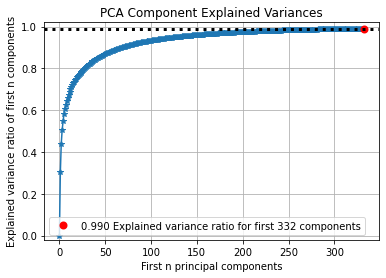

In [39]:
plot_pca_component_variance(model, target_explained_variance=target_explained_variance);

In [40]:
# Reconstructed from K components & original
model = PCA()
Z = model.fit_transform(X)
n = model.n_components_
K_init = [0]
@interact(i=(0,len(X)-1))
def __(i=7):
    y = np.zeros((n+1, X.shape[1]))
    y[0] = model.mean_
    for k in range(n):
        y[k + 1] = y[k] + Z[i][k]*model.components_[k]
    @interact(K=(0, n, 10))
    def _(K=K_init[0]):
        K_init[0] = K
        display_images(y[K:K+10])
    display_images(X[[i]])

interactive(children=(IntSlider(value=7, description='i', max=4999), Output()), _dom_classes=('widget-interact…

## Limitações

- O PCA é um método não-supervisionado de redução de dimensionalidade, que portanto não leva em conta o desempenho na tarefa final.
- O método tenta ao máximo preservar distâncias; logo, se a tarefa final for baseada em distância (euclidiana), espera-se que o desempenho não degrade muito.
- No entanto, se a distância euclidiana no espaço original não for uma boa métrica para a tarefa final, o PCA não vai amenizar o problema. Em outras palavras: de maneira geral, os atributos extraídos pelo PCA não fornecem uma representação dos dados melhor do que a original, apenas uma representação mais compacta.
- Para extrair bons atributos de imagens, por exemplo, seria provavelmente mais interessante usar uma rede convolucional.

In [41]:
K = 100
model = PCA(K, random_state=0)
Z = model.fit_transform(X)

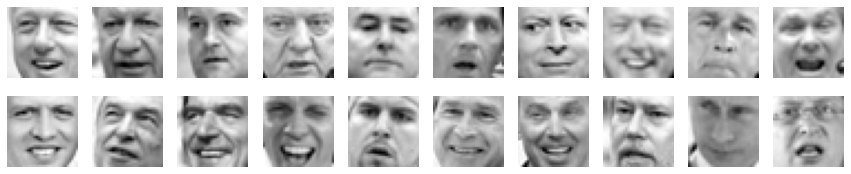

In [42]:
from sklearn.neighbors import NearestNeighbors

i = 25
nbrs = NearestNeighbors().fit(X)
_, indices = nbrs.kneighbors(X[[i]], n_neighbors=20)
display_images(X[indices[0]])

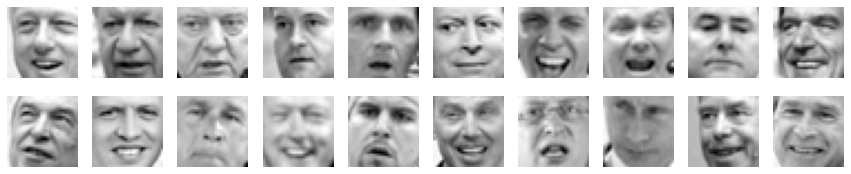

In [43]:
i = 25
nbrs = NearestNeighbors().fit(Z)
_, indices = nbrs.kneighbors(Z[[i]], n_neighbors=20)
display_images(X[indices[0]])

# Exemplo: PCA + K-Means no MNIST

Aqui, iremos refazer a clusterização do MNIST tendo antes pré-processado as imagens com PCA para reduzir sua dimensionalidade. O objetivo é acelerar o K-Means sem prejudicar significativamente os resultados.

In [44]:
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

(X, y) = mnist.load_data()[0]
X, y = shuffle(X, y, n_samples=10000, random_state=0)
X = X.reshape(X.shape[0], -1)/255
print(X.shape, y.shape)

(10000, 784) (10000,)


In [45]:
from sklearn.metrics.cluster import contingency_matrix
def purity(y_true, y_pred):
    return contingency_matrix(y_true, y_pred).max(axis=0).sum()/np.size(y_true)

In [46]:
import time

t0 = time.time()
model = KMeans(10, n_init=5, random_state=0).fit(X)
labels = model.labels_
centroids = model.cluster_centers_
dur_baseline = time.time() - t0
pur_baseline = purity(y, labels)
print('Baseline')
print('Cluster purity: {:.2%}'.format(pur_baseline))
print('Duration: {:g} seconds'.format(dur_baseline))

Baseline
Cluster purity: 57.82%
Duration: 2.05312 seconds


Centroids:


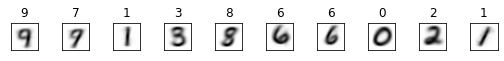

Clusters (first 8 images from each cluster):


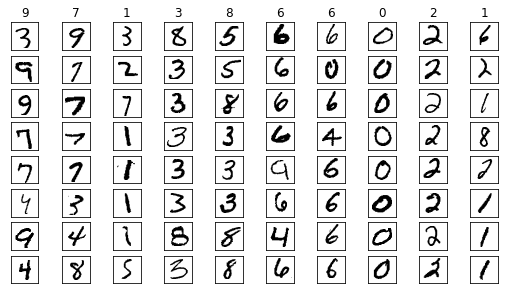

Purity within each cluster:
 34.7%  41.9%  69.5%  48.1%  45.7%  69.7%  69.8%  94.9%  91.5%  55.8%

Cluster sizes:
 1471   1428    932   1232   1082    587    788    839    751    890


In [47]:
M = contingency_matrix(y, labels)
best_map = M.argmax(axis=0)

print('Centroids:')
plt.figure(figsize=(9, 0.5))
for k in range(10):
    plt.subplot(1, 10, k+1)
    img = centroids[k].reshape(28, 28)
    plt.imshow(img, cmap='gray_r')
    plt.title(best_map[k])
    plt.xticks([]);
    plt.yticks([]);
plt.show()

rows = 8
print(f'Clusters (first {rows} images from each cluster):')
plt.figure(figsize=(9, 0.6*rows))
for i in range(rows):
    for k in range(10):
        plt.subplot(rows, 10, 10*i+k+1)
        img = X[labels == k][i].reshape(28, 28)
        plt.imshow(img, cmap='gray_r')
        if i == 0:
            plt.title(best_map[k])
        plt.xticks([]);
        plt.yticks([]);
plt.show()
purs = [M[best_map[k], k] for k in range(10)]/M.sum(axis=0)
print('Purity within each cluster:')
print(''.join([f'{a:7.1%}' for a in purs])[1:])
print('')
print('Cluster sizes:')
print(''.join([f'{s:7}' for s in M.sum(axis=0)])[2:])

In [48]:
N = 20

t0 = time.time()
pca = PCA(N, random_state=0)
Z = pca.fit_transform(X)
model = KMeans(10, n_init=5, random_state=0).fit(Z)
labels = model.labels_
centroids = pca.inverse_transform(model.cluster_centers_)
dur = time.time() - t0
pur = purity(y, labels)
print('PCA with {} components'.format(N))
print('Cluster purity: {:.2%}'.format(pur))
print('Duration: {:g} seconds'.format(dur))

PCA with 20 components
Cluster purity: 57.57%
Duration: 0.659262 seconds


Note que, para uma comparação justa, foi necessário incluir na medição de tempo decorrido o tempo para obter os centróides no espaço original de X (i.e., imagens).

Centroids:


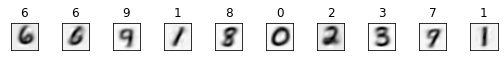

Clusters (first 8 images from each cluster):


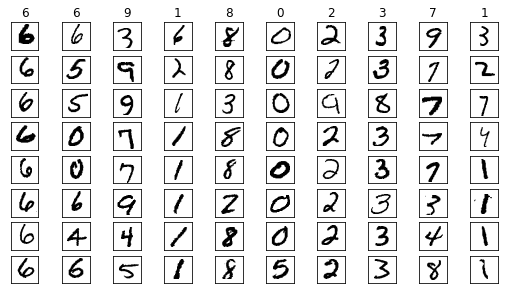

Purity within each cluster:
 86.6%  40.5%  34.1%  61.1%  59.6%  95.6%  91.0%  51.5%  42.4%  60.0%

Cluster sizes:
  658    888   1527    855    933    750    734   1219   1398   1038


In [49]:
M = contingency_matrix(y, labels)
best_map = M.argmax(axis=0)

print('Centroids:')
plt.figure(figsize=(9, 0.5))
for k in range(10):
    plt.subplot(1, 10, k+1)
    img = centroids[k].reshape(28, 28)
    plt.imshow(img, cmap='gray_r')
    plt.title(best_map[k])
    plt.xticks([]);
    plt.yticks([]);
plt.show()

rows = 8
print(f'Clusters (first {rows} images from each cluster):')
plt.figure(figsize=(9, 0.6*rows))
for i in range(rows):
    for k in range(10):
        plt.subplot(rows, 10, 10*i+k+1)
        img = X[labels == k][i].reshape(28, 28)
        plt.imshow(img, cmap='gray_r')
        if i == 0:
            plt.title(best_map[k])
        plt.xticks([]);
        plt.yticks([]);
plt.show()
purs = [M[best_map[k], k] for k in range(10)]/M.sum(axis=0)
print('Purity within each cluster:')
print(''.join([f'{a:7.1%}' for a in purs])[1:])
print('')
print('Cluster sizes:')
print(''.join([f'{s:7}' for s in M.sum(axis=0)])[2:])

Podemos calcular e traçar um gráfico da pureza e outro do tempo decorrido, ambos em função do número de componentes principais.

In [51]:
%%time

Ns = np.arange(1,51)
purs = np.zeros(len(Ns))
durs = np.zeros(len(Ns))
for i, N in enumerate(Ns):
    t0 = time.time()
    pca = PCA(N, random_state=0)
    Z = pca.fit_transform(X)
    model = KMeans(10, n_init=5, random_state=0).fit(Z)
    labels = model.labels_
    centroids = pca.inverse_transform(model.cluster_centers_)
    durs[i] = time.time() - t0
    purs[i] = purity(y, labels)

Wall time: 36.9 s


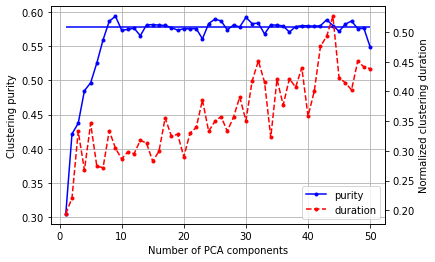

In [52]:
plt.xlabel('Number of PCA components')

plt.ylabel('Clustering purity')
lns = plt.plot(Ns, purs, 'b.-', label='purity');
plt.hlines(pur_baseline, Ns[0], Ns[-1], colors='b')
plt.grid()

plt.twinx()

plt.ylabel('Normalized clustering duration')
lns += plt.plot(Ns, durs/dur_baseline, 'r.--', label='duration');

plt.legend(lns, [ln.get_label() for ln in lns], loc='lower right');